In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json 
from fvm_model_parallel import cu_solve
from numba import cuda

In [2]:
def make_init_cond(t_dom, central_ini_cond, ini_cond_var, k):
    n_it = int(((t_dom[1] - t_dom[0]) / (k))) + 1

    initial_cond = np.linspace(
        central_ini_cond * (1 - ini_cond_var),
        central_ini_cond * (1 + ini_cond_var),
        num=n_it,
        endpoint=True,
    )

    print(
        "Steps in time = {:d}\n".format(
            n_it,
        )
    )

    return n_it, initial_cond

# Definições iniciais

In [4]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

phi = constant_properties["phi"]
ksi = constant_properties["ksi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
central_ini_cond = constant_properties["central_ini_cond"]
ini_cond_var = constant_properties["ini_cond_var"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

k = mesh_properties["k"]
t_dom = mesh_properties["t_dom"]

size_t, initial_list = make_init_cond(t_dom, central_ini_cond, ini_cond_var, k)


t_np = np.linspace(t_dom[0], t_dom[1], num=size_t, endpoint=True)

# Computing FDM model

struct_name = (
    "k--" + str(k) + "__t_lower--" + str(t_dom[0]) + "__t_upper--" + str(t_dom[1])
)

print("struct_name: ", struct_name)

threadsperblock = size_t
blockspergrid = (1)

Cp_final_device = cuda.to_device(np.zeros((size_t,size_t)))
Cl_final_device = cuda.to_device(np.zeros((size_t,size_t)))
initial_cond_device = cuda.to_device(initial_list)

cu_solve[threadsperblock,blockspergrid](
    Cp_final_device,
    Cl_final_device,
    initial_cond_device,
    size_t,
    cb,
    lambd_nb,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    k,
    phi,
)


Cp_fvm = np.empty(shape=Cp_final_device.shape, dtype=Cp_final_device.dtype)
Cp_final_device.copy_to_host(Cp_fvm)

Cl_fvm = np.empty(shape=Cl_final_device.shape, dtype=Cl_final_device.dtype)
Cl_final_device.copy_to_host(Cl_fvm)

with open("fvm_sim/Cp__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cp_fvm, f)

with open("fvm_sim/Cl__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cl_fvm, f)

Steps in time = 2001

struct_name:  k--0.005__t_lower--0__t_upper--10


# Análise de nullclines

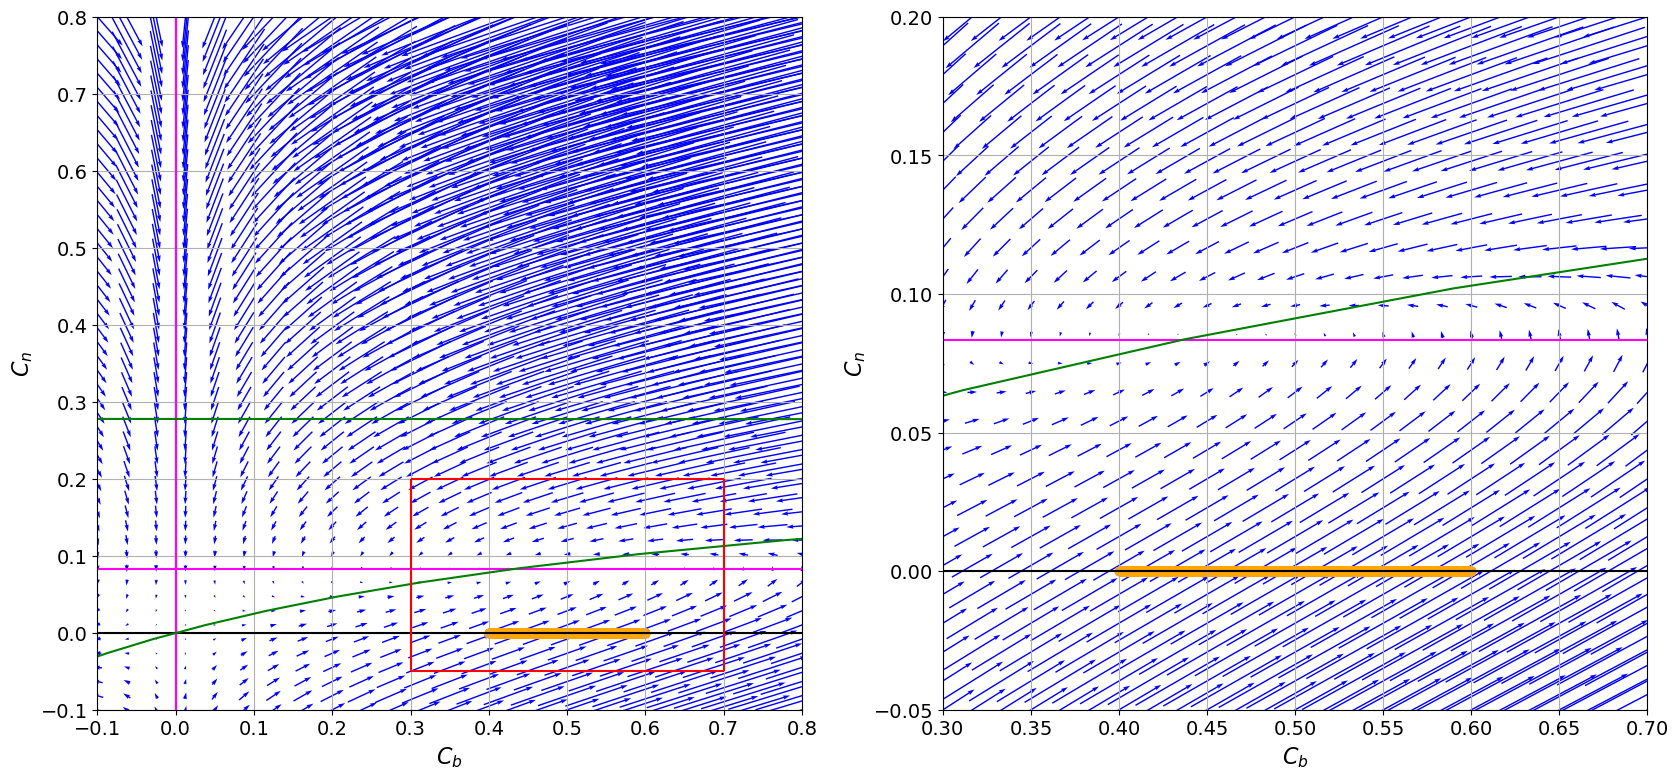

In [5]:
fig = plt.figure(figsize=[20, 9])

# fig.suptitle("Plano de fases", fontsize=16)


# Plotango 3D
ax = fig.add_subplot(1, 2, 1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

x_lim = (-0.1, 0.8)
y_lim = (-0.1, 0.8)

const_cl = cb / lambd_nb

cp_eval = np.linspace(x_lim[0], x_lim[1], num=25, endpoint=True)
cl_eval = np.linspace(y_lim[0], y_lim[1], endpoint=True)

nulc_1 = [const_cl for i in range(len(cl_eval))]
nulc_2 = [0 for i in range(len(cl_eval))]

nulc_3 = mi_n * cl_eval / (y_n * (Cn_max - cl_eval) - lambd_bn * cl_eval)

# Meshgrid
x, y = np.meshgrid(cp_eval, cl_eval)

# Directional vectors
u = (cb * x - lambd_nb * y * x) / phi
v = (y_n * x * (Cn_max - y) - lambd_bn * x * y - mi_n * y) / phi

ax.set_xlabel("$C_b$", fontsize=16)
ax.set_ylabel("$C_n$", fontsize=16)

ax.hlines(0, x_lim[0], x_lim[1], "k")
ax.vlines(0, y_lim[0], y_lim[1], "k")


ax.plot(cl_eval, nulc_1, "magenta")

ax.plot(nulc_2, cl_eval, "magenta")

ax.plot(nulc_3, cl_eval, "g")

# Plotting Vector Field with QUIVER
ax.quiver(
    x,
    y,
    u,
    v,
    color="b",
    width=0.002,
    angles="xy",
    scale_units="xy",
    scale=10,
    pivot="mid",
)

# Plotando valores de condições iniciais estudados
ax.scatter(initial_list, [0 for i in range(len(initial_list))], color="orange")


ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])

x_lim = (0.3, 0.7)
y_lim = (-0.05, 0.2)

ax.hlines(y_lim[1], x_lim[0], x_lim[1], color="r")
ax.hlines(y_lim[0], x_lim[0], x_lim[1], color="r")
ax.vlines(x_lim[1], y_lim[0], y_lim[1], color="r")
ax.vlines(x_lim[0], y_lim[0], y_lim[1], color="r")

ax.grid()

# Plotango 3D
ax = fig.add_subplot(1, 2, 2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

const_cl = cb / lambd_nb

cp_eval_2 = np.linspace(x_lim[0], x_lim[1], num=25, endpoint=True)
cl_eval_2 = np.linspace(y_lim[0], y_lim[1], num=25, endpoint=True)

# Meshgrid
x, y = np.meshgrid(cp_eval_2, cl_eval_2)

# Directional vectors
u = (cb * x - lambd_nb * y * x) / phi
v = (y_n * x * (Cn_max - y) - lambd_bn * x * y - mi_n * y) / phi

ax.set_xlabel("$C_b$", fontsize=16)
ax.set_ylabel("$C_n$", fontsize=16)

ax.hlines(0, x_lim[0], x_lim[1], "k")
ax.vlines(0, y_lim[0], y_lim[1], "k")

ax.plot(cl_eval, nulc_1, "magenta")

ax.plot(nulc_2, cl_eval, "magenta")

ax.plot(nulc_3, cl_eval, "g")

# Plotting Vector Field with QUIVER
ax.quiver(
    x,
    y,
    u,
    v,
    color="b",
    width=0.002,
    angles="xy",
    scale_units="xy",
    scale=10,
    pivot="mid",
)

# Plotando valores de condições iniciais estudados
ax.scatter(initial_list, [0 for i in range(len(initial_list))], color="orange")

ax.grid()
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])

plt.show()

# PINN

In [6]:
tt, ii = np.meshgrid(t_np, initial_list)

data_input_np = np.array([Cl_fvm.flatten(), Cp_fvm.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    initial = (
        torch.tensor(ii, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    initial = torch.tensor(ii, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

print(device)

cuda


In [7]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [8]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [9]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](2, int(out_neurons)))

                else:
                    modules.append(nn.Linear(2, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [10]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [11]:
def normalize_torch(dataset):
    with torch.no_grad():
        dt_min = torch.min(dataset, 0).values
        dt_max = torch.max(dataset, 0).values
        normalized = (dataset - dt_min) / (dt_max - dt_min)

    return normalized.requires_grad_(True), dt_min, dt_max

In [12]:
def normalize_data_input(data_input, steps):
    with torch.no_grad():
        dataset = data_input.reshape(steps, steps, 2)
        normalized = torch.zeros_like(dataset)
        for i in range(len(dataset)):
            dt_min = torch.min(dataset[i], 0).values
            dt_max = torch.max(dataset[i], 0).values
            normalized[i] = (dataset[i] - dt_min) / (dt_max - dt_min)

    return normalized.reshape((steps) * (steps), 2)

In [13]:
def rescale(dataset, dt_min, dt_max):
    return (dt_max - dt_min) * dataset + dt_min

In [14]:
def shuffle_data(x, y, z):
    Data_num = np.arange(x.shape[0])
    np.random.shuffle(Data_num)

    return x[Data_num], y[Data_num], z[Data_num]

In [15]:
def train_test_split(x, y, z, test_size=0.5, shuffle=True):
    with torch.no_grad():
        if shuffle:
            x, y, z = shuffle_data(x, y, z)
        if test_size < 1:
            train_ratio = len(x) - int(len(x) * test_size)
            x_train, x_test = x[:train_ratio], x[train_ratio:]
            y_train, y_test = y[:train_ratio], y[train_ratio:]
            z_train, z_test = z[:train_ratio], z[train_ratio:]
            return (
                x_train.requires_grad_(True),
                x_test.requires_grad_(True),
                y_train.requires_grad_(True),
                y_test.requires_grad_(True),
                z_train.requires_grad_(True),
                z_test.requires_grad_(True),
            )
        elif test_size in range(1, len(x)):
            x_train, x_test = x[test_size:], x[:test_size]
            y_train, y_test = y[test_size:], y[:test_size]
            z_train, z_test = z[test_size:], z[:test_size]
            return (
                x_train.requires_grad_(True),
                x_test.requires_grad_(True),
                y_train.requires_grad_(True),
                y_test.requires_grad_(True),
                z_train.requires_grad_(True),
                z_test.requires_grad_(True),
            )

In [16]:
def initial_condition(initial):
    Cl = torch.zeros_like(initial)
    return torch.cat([Cl, initial], dim=1)

In [17]:
def pde(t, initial, model):
    mesh = torch.cat([t, initial], dim=1)

    Cl, Cp = model(mesh).split(1, dim=1)

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Calculando Cp

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    return torch.cat([dCl_dt, dCp_dt], dim=1)

In [18]:
def train(
    n_epochs,
    batch_size,
    decay_rate,
    model,
    initial,
    device,
    data_input,
    t,
    norm_weights=None,
    validation=None,
):
    dt_min, dt_max = norm_weights if norm_weights else (0, 1)

    loss_fn = nn.MSELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer, gamma=decay_rate
    )

    if validation:
        train_data, test_data, train_t, test_t, train_initial, test_initial = (
            train_test_split(data_input, t, initial, test_size=validation)
        )
        train_data_input = torch.cat([train_t, train_initial], dim=1)
        test_data_input = torch.cat([test_t, test_initial], dim=1)

    else:
        train_data = data_input
        test_data = None
        train_data_input = torch.cat([t, initial], dim=1)
        test_data_input = None
        train_t = t
        test_t = None
        train_initial = initial
        test_initial = None

    C_pde_loss_it = torch.zeros(n_epochs).to(device)
    C_data_loss_it = torch.zeros(n_epochs).to(device)
    C_initial_loss_it = torch.zeros(n_epochs).to(device)
    C_initial = initial_condition(train_initial).to(device)
    val_loss_it = torch.zeros(n_epochs).to(device)

    for epoch in range(n_epochs):
        for i in range(0, len(train_t), batch_size):
            t_initial = torch.zeros_like(train_t[i : i + batch_size])

            mesh_ini = torch.cat([t_initial, train_initial[i : i + batch_size]], dim=1)
            C_initial_pred = model(mesh_ini)

            loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

            Cl, Cp = model(train_data_input[i : i + batch_size]).split(1, dim=1)

            Cl_eq = (y_n * Cp * (Cn_max - Cl) - lambd_bn * Cp * Cl - mi_n * Cl) / (
                phi * (dt_max - dt_min)
            )
            Cp_eq = (cb * Cp - lambd_nb * Cl * Cp) / (phi * (dt_max - dt_min))

            pde_pred = torch.cat([Cl_eq, Cp_eq], dim=1)

            loss_pde = loss_fn(
                pde(
                    train_t[i : i + batch_size],
                    train_initial[i : i + batch_size],
                    model,
                ),
                pde_pred,
            )

            C_pred = torch.cat([Cl, Cp], dim=1)

            loss_data = loss_fn(train_data[i : i + batch_size], C_pred)

            loss = 15 * loss_initial + loss_pde + 40 * loss_data

            if validation:
                with torch.no_grad():
                    val_loss = loss_fn(test_data, model(test_data_input))
            # val_loss = torch.tensor([0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        C_pde_loss_it[epoch] = loss_pde.item()
        C_initial_loss_it[epoch] = loss_initial.item()
        C_data_loss_it[epoch] = loss_data.item()
        val_loss_it[epoch] = val_loss.item() if validation else 0

        if (epoch % 100) == 0:
            print(
                f"Finished epoch {epoch+1}, latest loss {loss}, validation loss {val_loss.item()}"
                if validation
                else f"Finished epoch {epoch+1}, latest loss {loss}"
            )

    return model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it, val_loss_it

In [22]:
decay_rate = 0.999
n_epochs = 300
batch_size = 400400

model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it, val_loss_it = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial=initial,
    device=device,
    data_input=data_input,
    t=t,
    validation=0.1,
)

0 1
Finished epoch 1, latest loss 0.052315451204776764, validation loss 0.0010627936571836472
Finished epoch 101, latest loss 2.8216716600582004e-05, validation loss 8.431756214122288e-06
Finished epoch 201, latest loss 2.0985384253435768e-05, validation loss 7.056979029584909e-06


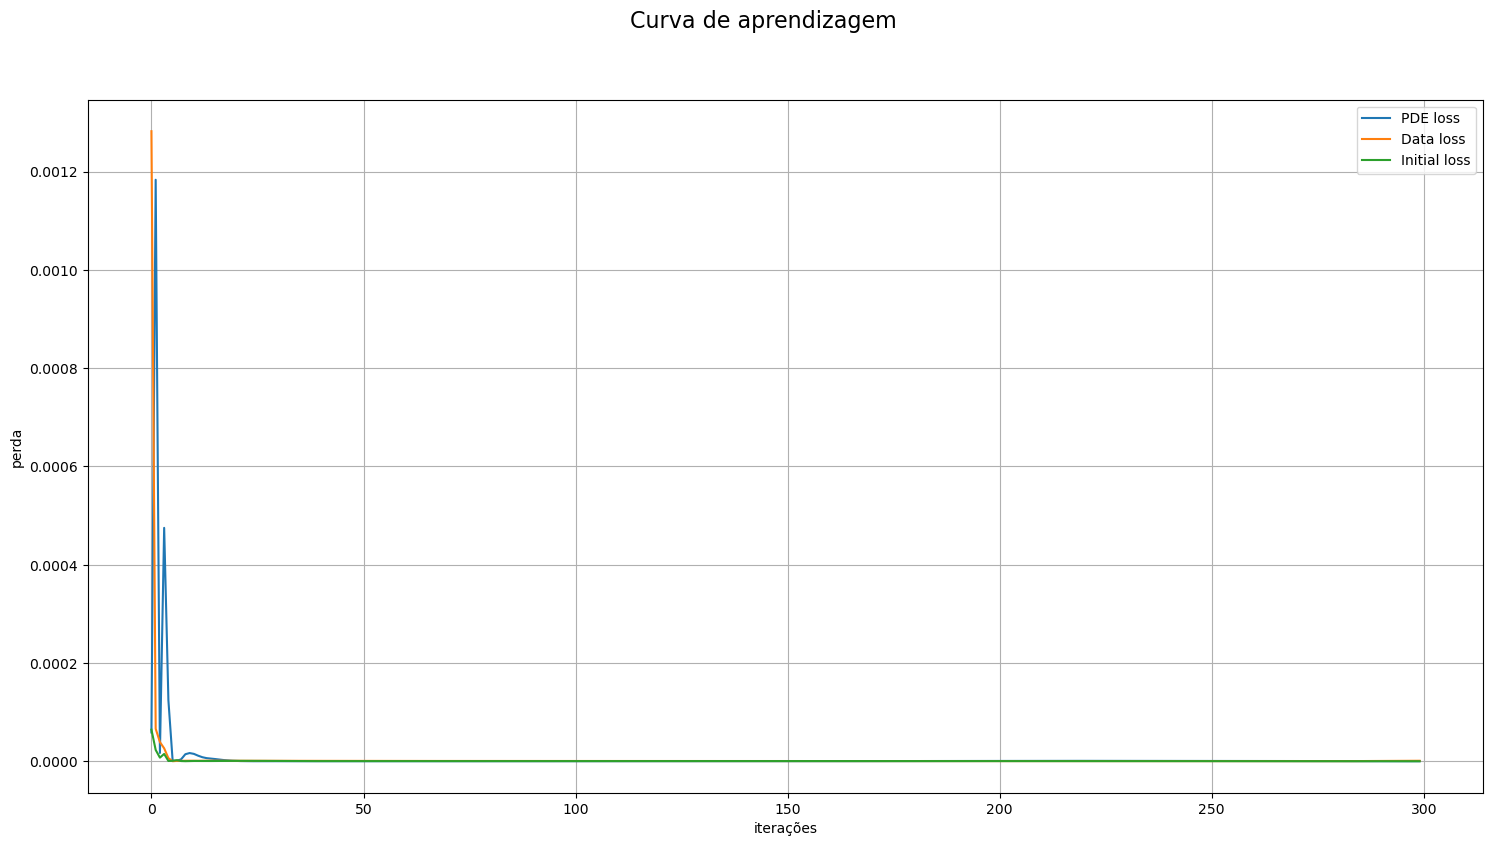

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

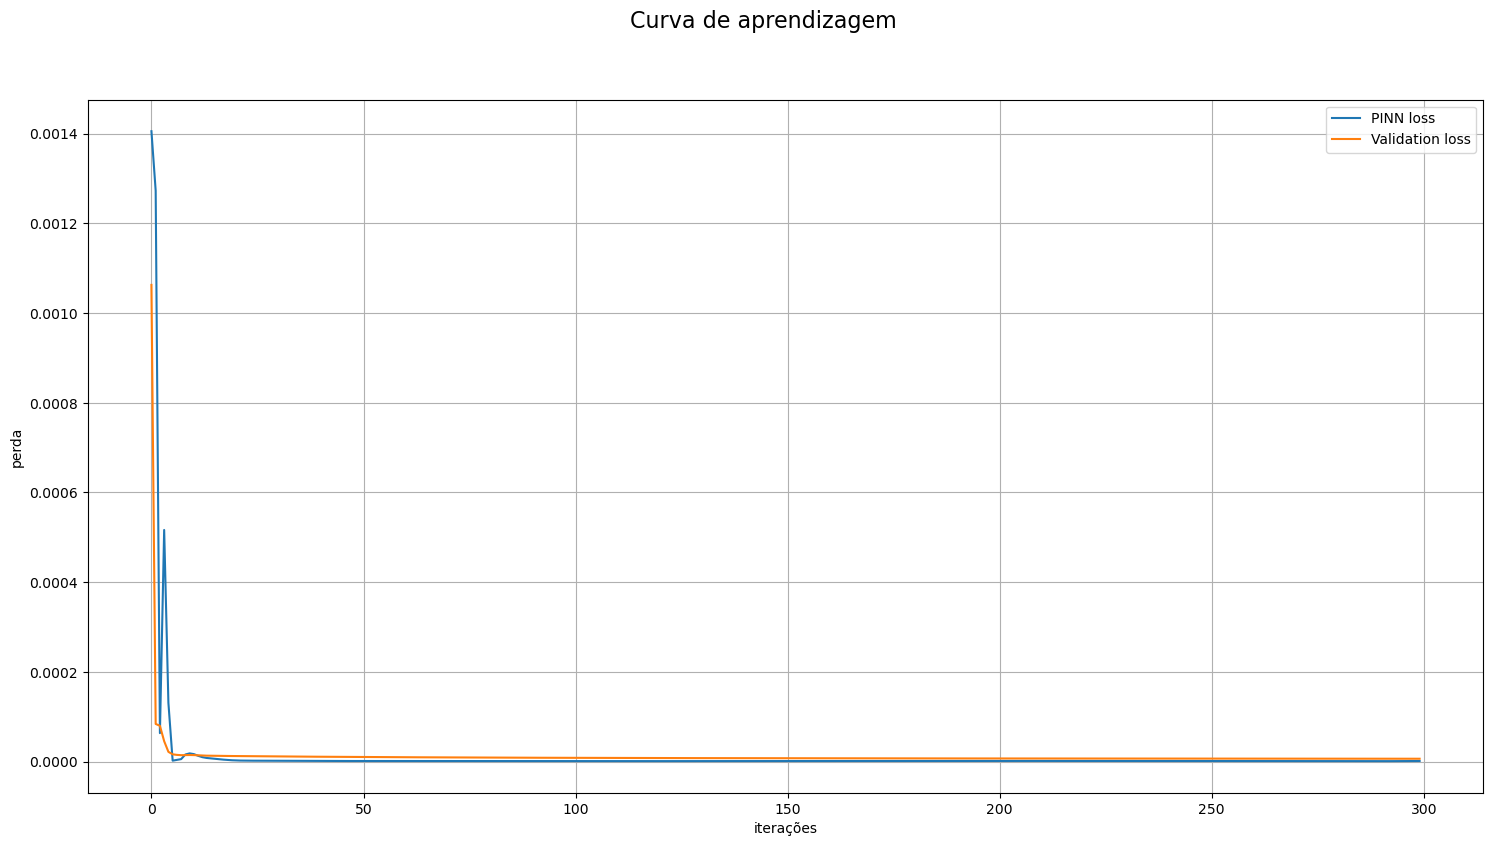

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy()
    + C_pde_loss_it.cpu().numpy()
    + C_data_loss_it.cpu().numpy(),
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

# Saving model weights and biases

In [25]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
0.weight 	 torch.Size([32, 2])
0.bias 	 torch.Size([32])
2.weight 	 torch.Size([32, 32])
2.bias 	 torch.Size([32])
4.weight 	 torch.Size([32, 32])
4.bias 	 torch.Size([32])
6.weight 	 torch.Size([32, 32])
6.bias 	 torch.Size([32])
8.weight 	 torch.Size([2, 32])
8.bias 	 torch.Size([2])


In [38]:
import os

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + arch_str + ".pt")

In [39]:
model = generate_model(arch_str).to(device)

model.load_state_dict(torch.load(cwd + "/nn_parameters/" + arch_str + ".pt", weights_only=True))

model.eval()

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)

# Comparizon between models

In [40]:
speed_up = []

mesh = torch.cat([t, initial], dim=1).to(device)

for i in range(10):
    fdm_start = time.time()

    threadsperblock = size_t
    blockspergrid = (1)

    Cp_final_device = cuda.to_device(np.zeros((size_t,size_t)))
    Cl_final_device = cuda.to_device(np.zeros((size_t,size_t)))
    initial_cond_device = cuda.to_device(initial_list)

    cu_solve[threadsperblock,blockspergrid](
        Cp_final_device,
        Cl_final_device,
        initial_cond_device,
        size_t,
        cb,
        lambd_nb,
        y_n,
        Cn_max,
        lambd_bn,
        mi_n,
        k,
        phi,
    )


    Cp_fvm = np.empty(shape=Cp_final_device.shape, dtype=Cp_final_device.dtype)
    Cp_final_device.copy_to_host(Cp_fvm)

    Cl_fvm = np.empty(shape=Cl_final_device.shape, dtype=Cl_final_device.dtype)
    Cl_final_device.copy_to_host(Cl_fvm)

    fdm_end = time.time()

    pinn_start = time.time()

    with torch.no_grad():
        Cl_pinn_device, Cp_pinn_device = model(mesh).split(1, dim=1)

    Cl_pinn = Cl_pinn_device.cpu().detach().numpy()
    Cp_pinn = Cp_pinn_device.cpu().detach().numpy()

    pinn_end = time.time()

    fdm_time = fdm_end - fdm_start

    pinn_time = pinn_end - pinn_start

    speed_up.append(fdm_time / pinn_time)

In [41]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_fvm.flatten(), Cp_fvm.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_fvm.flatten(), Cp_fvm.flatten()
        )
    ]
)

In [42]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [43]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.0026221631480805524
Erro absoluto máximo 0.017301057474130244
Speed Up: 0.7280244173677828 +/-0.07106447621967951


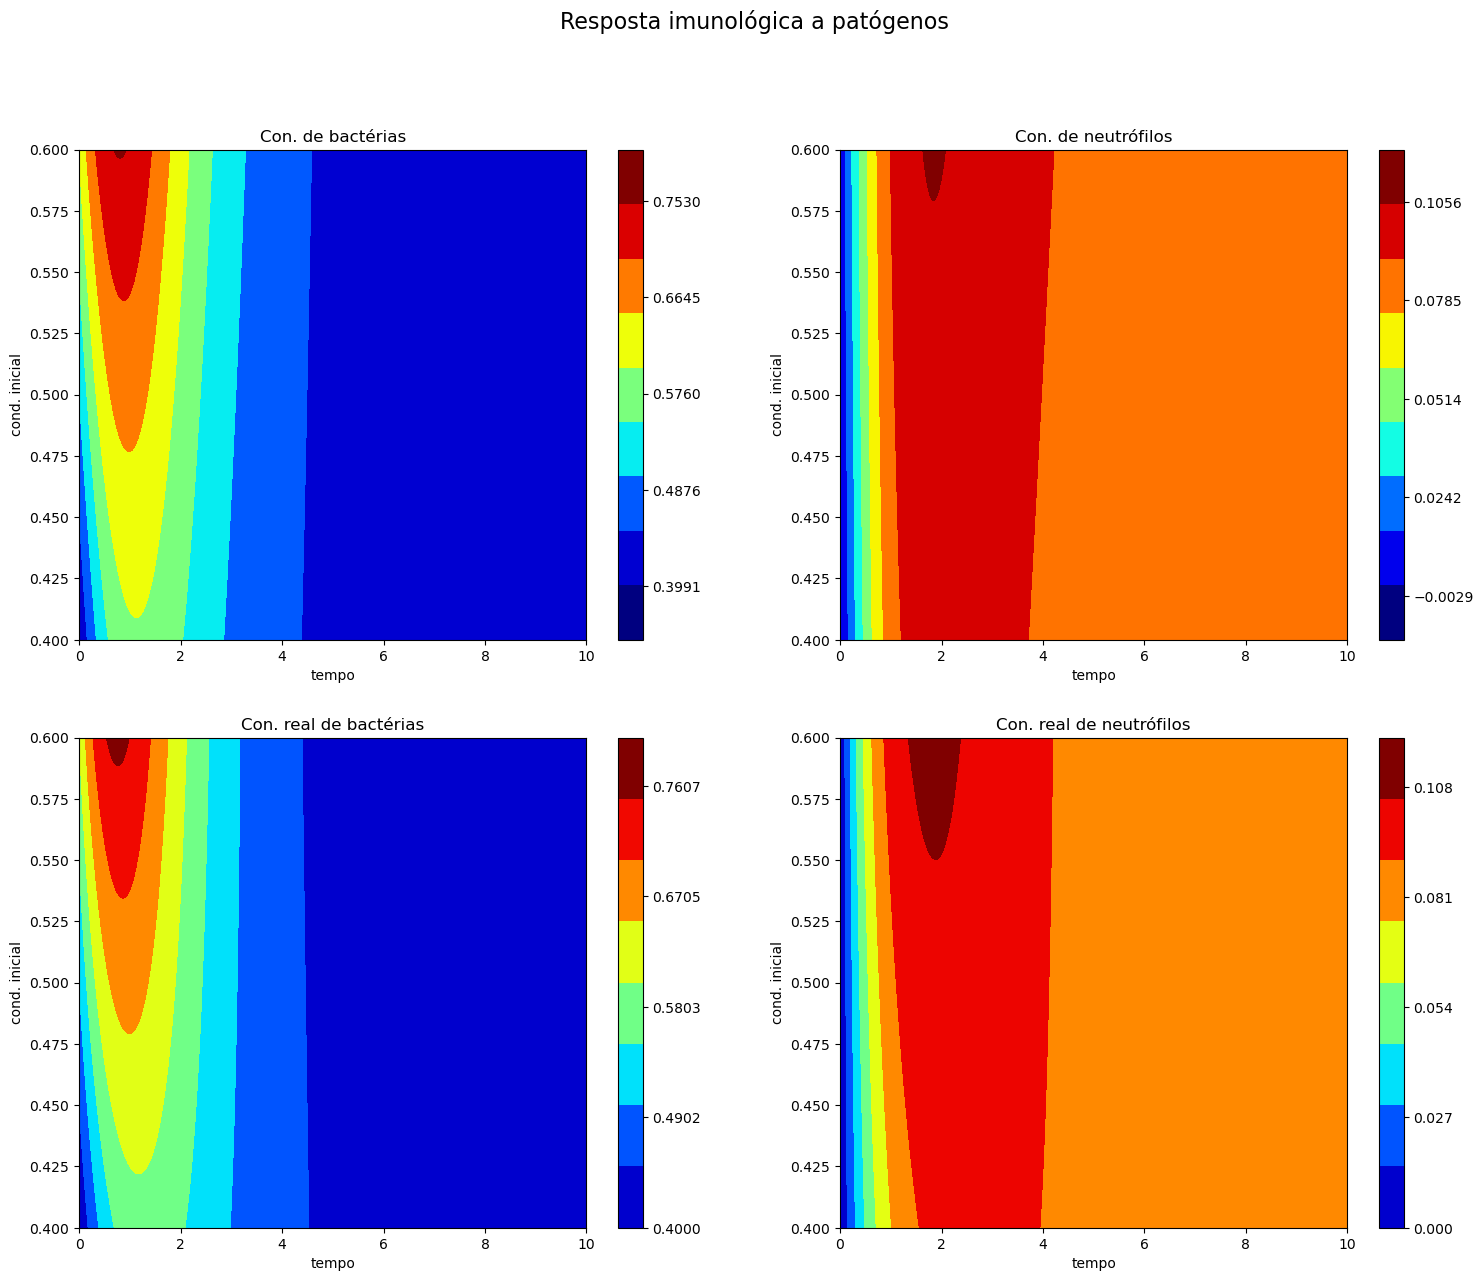

In [46]:
Cl_pinn_np = Cl_pinn.reshape(size_t, size_t)
Cp_pinn_np = Cp_pinn.reshape(size_t, size_t)

fig = plt.figure(figsize=[18, 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

vmin = np.min(Cp_pinn_np)
vmax = np.max(Cp_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

vmin = np.min(Cl_pinn_np)
vmax = np.max(Cl_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

vmin = np.min(Cp_fvm)
vmax = np.max(Cp_fvm)

contour = ax.contourf(
    tt,
    ii,
    Cp_fvm.reshape(size_t, size_t),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

vmin = np.min(Cl_fvm)
vmax = np.max(Cl_fvm)

contour = ax.contourf(
    tt,
    ii,
    Cl_fvm.reshape(size_t, size_t),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

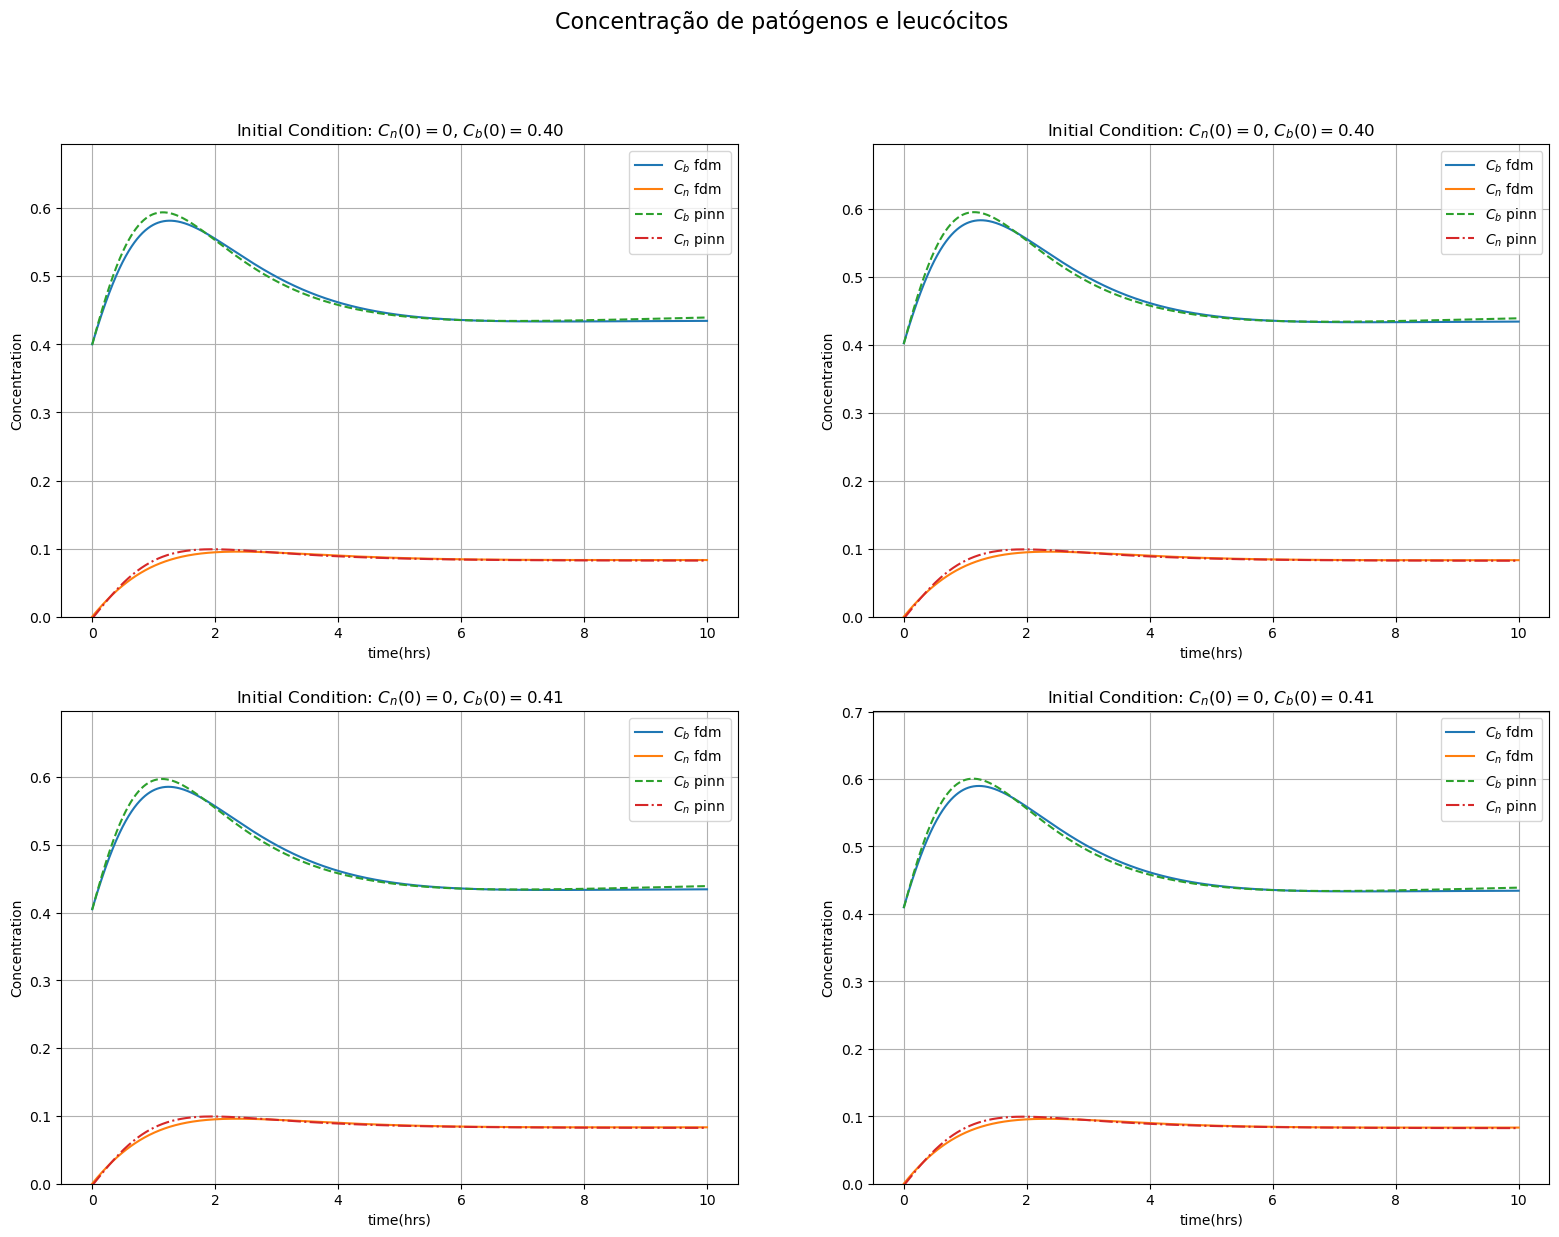

In [49]:
t_np = np.linspace(0, 10, num=size_t, endpoint=True)

tt, ii = np.meshgrid(t_np, initial_list)

fig = plt.figure(figsize=[16 * 1.2, 9 * 1.5])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

ini_cond_plot = [0,25,50,99]

for i,ini_position in enumerate(ini_cond_plot):

    cp_fvm = Cp_fvm[ini_position, :]
    cl_fvm = Cl_fvm[ini_position, :]
    cp_pinn = Cp_pinn_np[ini_position, :]
    cl_pinn = Cl_pinn_np[ini_position, :]
    ini = initial_list[ini_position]

    # Plotango 3D
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title("Initial Condition: $C_n(0) = 0$, $C_b(0) = {:.2f}$".format(ini))

    ax.plot(t_np, cp_fvm, label="$C_b$ fdm")
    ax.plot(t_np, cl_fvm, label="$C_n$ fdm")
    ax.plot(t_np, cp_pinn, "--", label="$C_b$ pinn")
    ax.plot(t_np, cl_pinn, "-.", label="$C_n$ pinn")
    ax.set_xlabel("time(hrs)")
    ax.set_ylabel("Concentration")

    vmax = np.max(
        [
            np.max(cp_fvm),
            np.max(cl_fvm),
            np.max(cp_pinn),
            np.max(cl_pinn),
        ]
    )
    ax.set_ylim(vmin, vmax + 0.1)
    ax.legend()
    ax.grid()

plt.show()